Dataset:

https://www.kaggle.com/shivam2503/diamonds/download

### Import libraries and the dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics

data = pd.read_csv("diamonds.csv")
data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


### Data Processing

In [2]:
#Dropping dimensionless diamonds
data = data.drop(data[data["x"]==0].index)
data = data.drop(data[data["y"]==0].index)
data = data.drop(data[data["z"]==0].index)

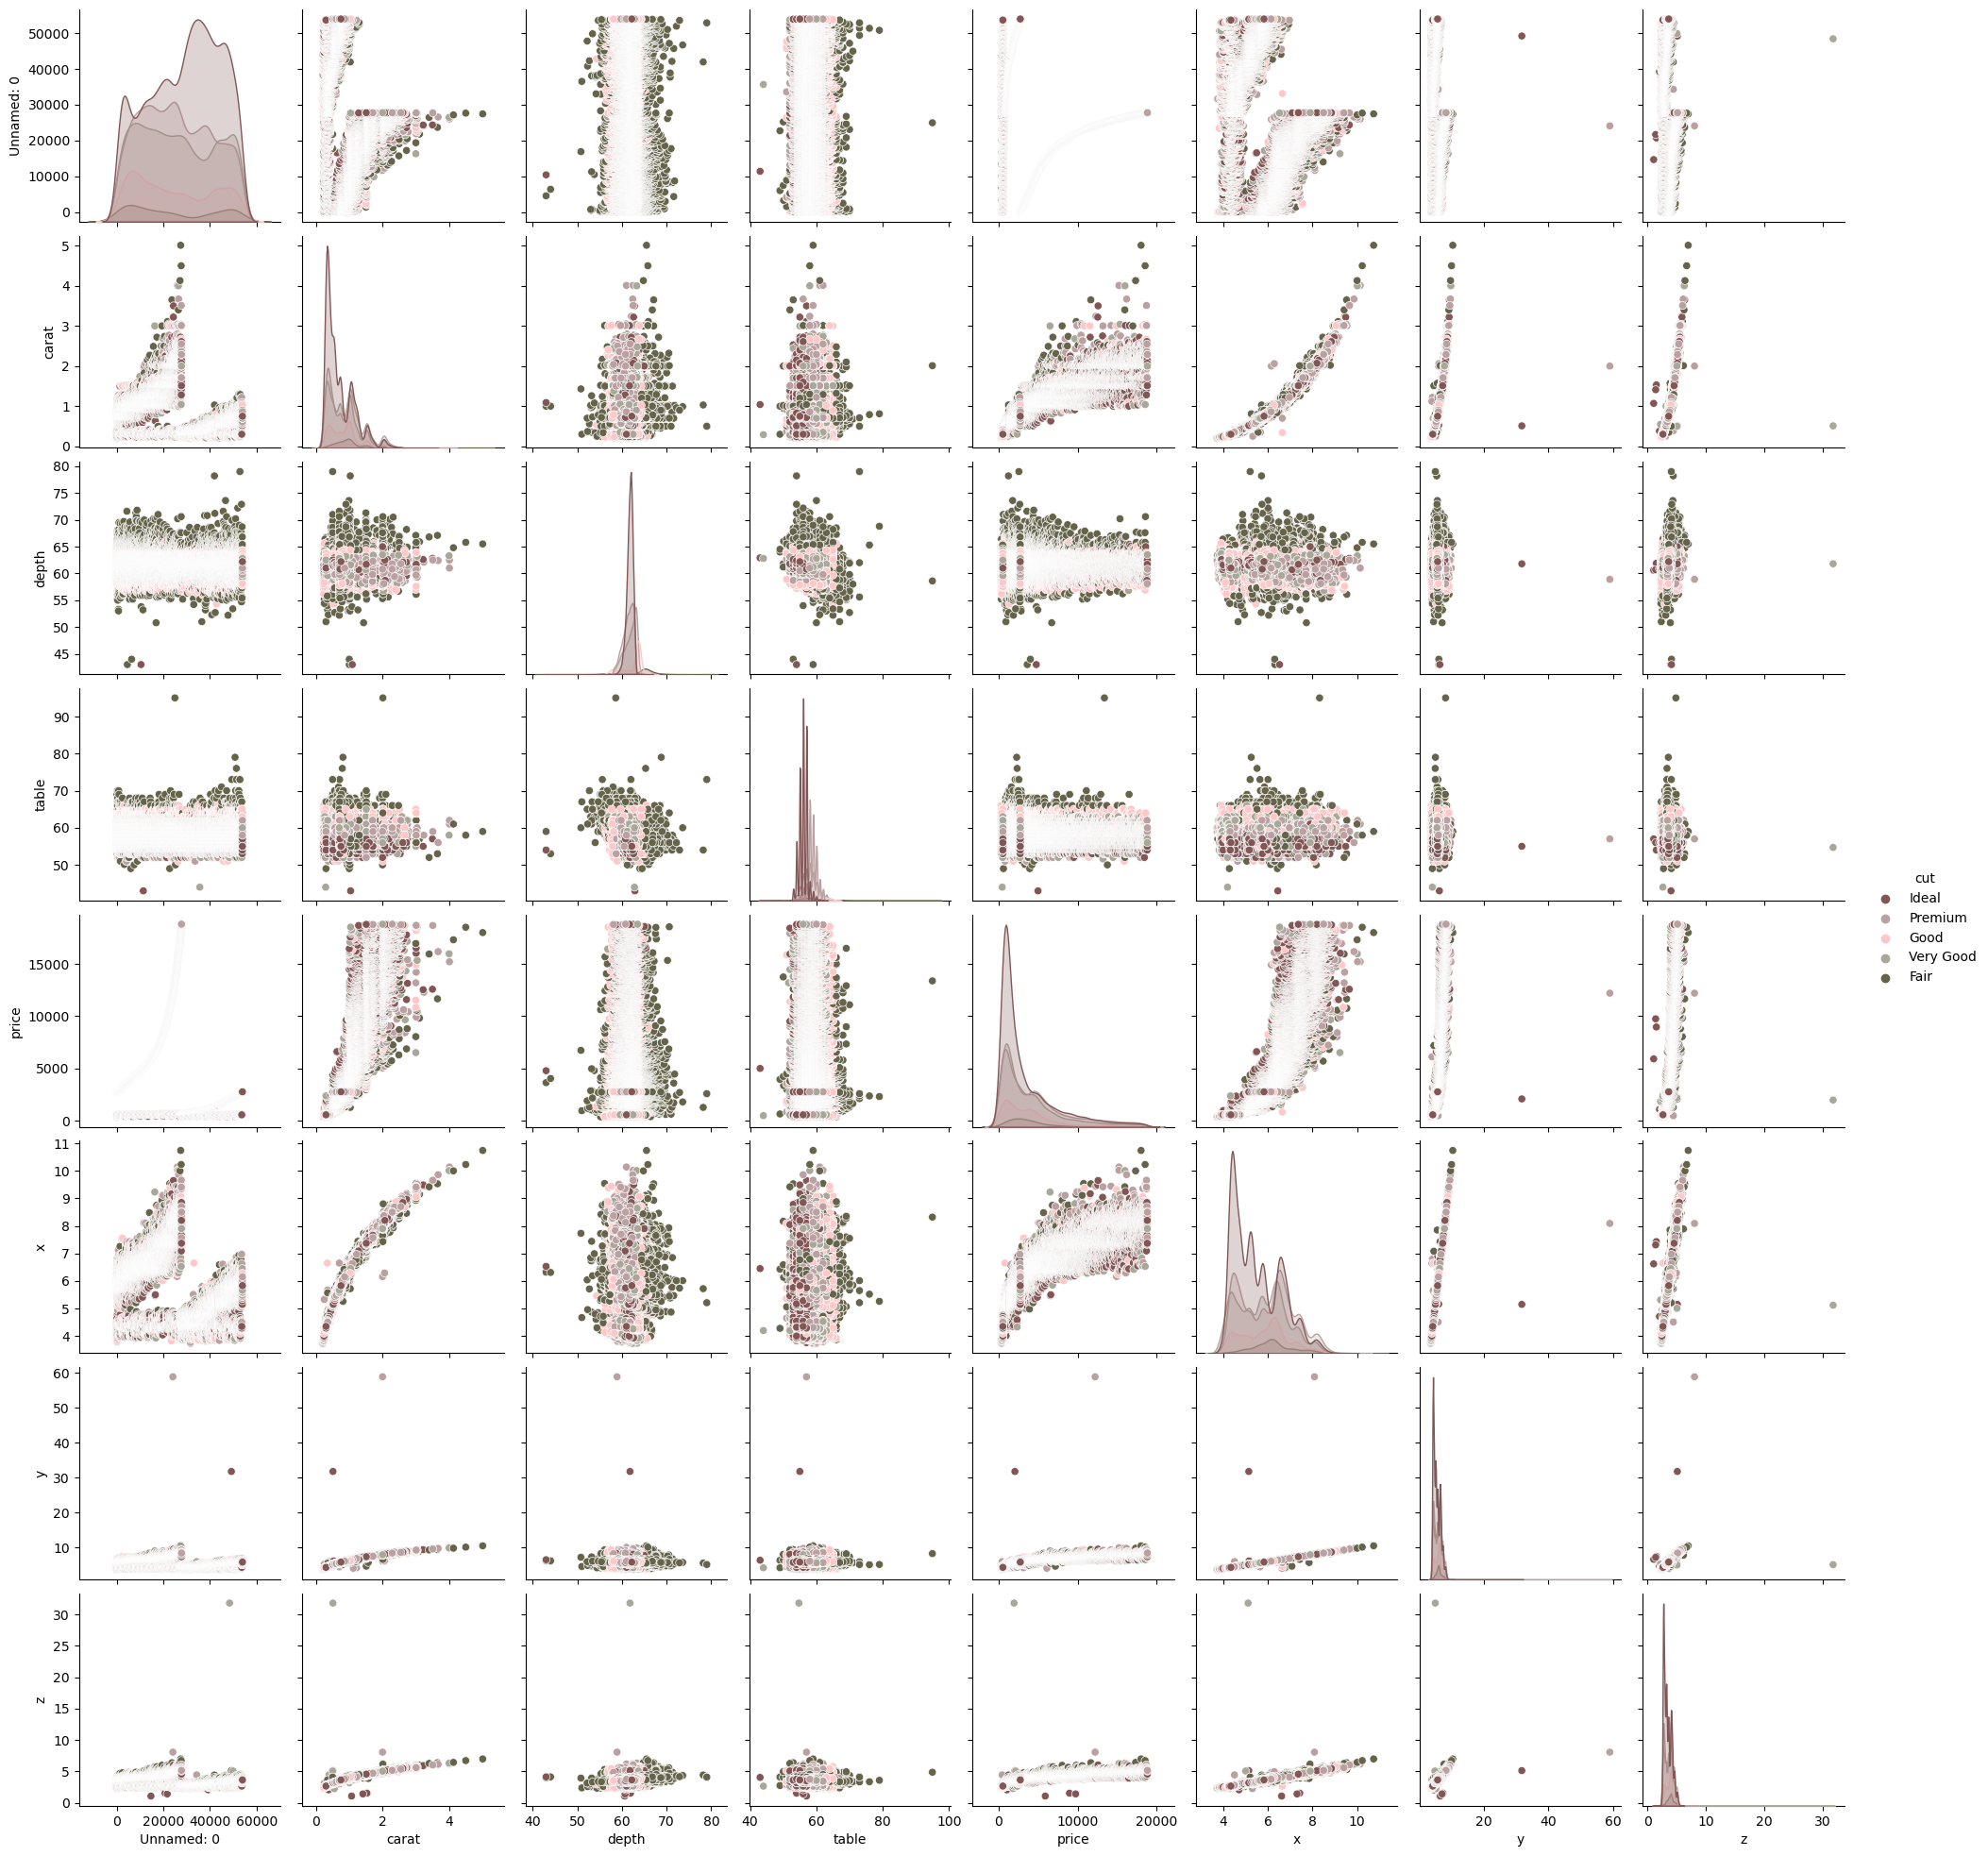

In [4]:
shade = ["#835656","#baa0a0","#ffc7c8",
         "#a9a799","#65634a"] # Shades for hue
ax = sns.pairplot(data,
                  hue="cut",palette=shade)

Some features with a data point that are far from the rest of the dataset will affect the outcome of our regression model, such as:

  1.  y and z have dimensional outliers in our dataset that need to be eliminated.
  2.  The depth should be capped but we have to look at the regression line to be sure.
  3.  The table presented must also be capped.

Now let’s remove all the outliers in the dataset:

In [6]:
#Dropping the outliers.
data = data[(data["depth"]<75)&(data["depth"]>45)]
data = data[(data["table"]<80)&(data["table"]>40)]
data = data[(data["x"]<30)]
data = data[(data["y"]<30)]
data = data[(data["z"]<30)&(data["z"]>2)]

In [7]:
# Categorical features
s = (data.dtypes == "object")
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)

Categorical variables:
['cut', 'color', 'clarity']


In [8]:
label_data = data.copy()

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    label_data[col] = label_encoder.fit_transform(label_data[col])

Finally, let’s have a look at the correlation between the features before training a model for the task of Diamond Price prediction:

<Axes: >

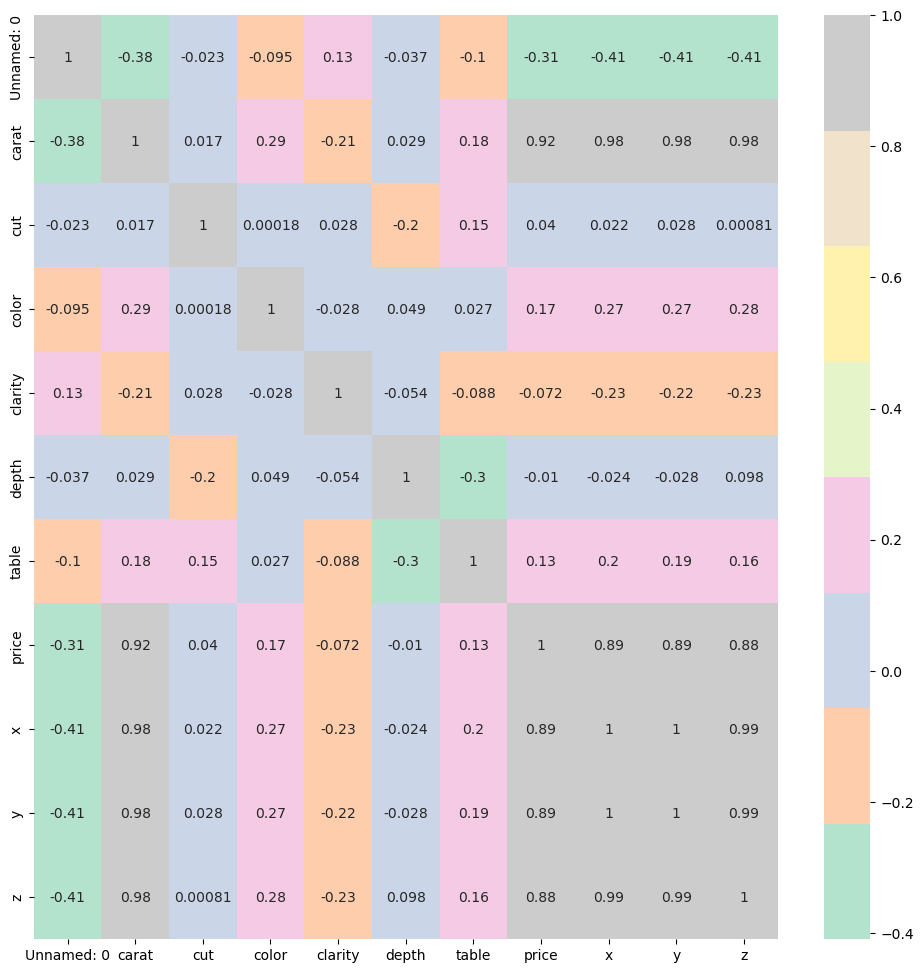

In [10]:
corrmat = label_data.corr()
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corrmat, cmap="Pastel2",annot=True)

### Observations:

  1.  x, y and z show a strong correlation with the target column.
  2.  The depth, cut and table columns show a weak correlation. We might consider giving up but let’s keep it.

### Final Step: Dimond Price Prediction Model

Now let’s move to the final step for the task of creating a machine learning model for predicting the price of diamonds. Below is the complete process that we need to follow in this step:

  1.  Features and target configuration
  2.  Create a pipeline of scalars and standard models for five different regressors.
  3.  Fit all models to training data
  4.  Obtain the cross-validation mean on the training set for all negative mean squared error models
  5.  Choose the model with the best cross-validation score
  6.  Ride the best model on the training set

Now let’s implement all the steps mentioned above to train a machine learning model for the task of Diamond Price Prediction:

In [12]:
# Assigning the features as X and target as y
X = label_data.drop(["price"],axis=1)
y = label_data["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

# Building pipelines of standard scaler and model for various regressors
pipeline_lr = Pipeline([("scalar1",StandardScaler()),
                           ("lr_calssifier",LinearRegression())])

pipeline_dt = Pipeline([("scalar2",StandardScaler()),
                        ("dt_classifier",DecisionTreeRegressor())])

pipeline_rf = Pipeline([("scalar3",StandardScaler()),
                        ("rf_classifier",RandomForestRegressor())])

pipeline_kn = Pipeline([("scalar4",StandardScaler()),
                        ("rf_classifier",KNeighborsRegressor())])

pipeline_xgb = Pipeline([("scalar5",StandardScaler()),
                         ("rf_classifier",XGBRegressor())])

# List of all pipelines
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_kn, pipeline_xgb]

# Dictionary pf pipelines and model types for ease of reference
pipe_dict = {0: "LinearRegression", 1:"decisionTree", 2:"RandomForest", 3:"KNeighbors", 4:"XGBRegressor"}

# fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

cv_results_rms = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train, y_train, scoring="neg_root_mean_squared_error",cv=10)
    cv_results_rms.append(cv_score)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

LinearRegression: -1344.798387 
decisionTree: -52.307961 
RandomForest: -35.498675 
KNeighbors: -666.216132 
XGBRegressor: -42.600360 


From the above scores, XGBClassifier appears to be the model with the best score on the negative mean squared error. Let’s test this model on the test set and evaluate with different parameters:

In [13]:
pred = pipeline_xgb.predict(X_test)
print("R^2:",metrics.r2_score(y_test, pred))
print("Adjusted R^2:", 1 - (1 - metrics.r2_score(y_test, pred)) * (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print("MAE:",metrics.mean_absolute_error(y_test, pred))
print("MSE:",metrics.mean_squared_error(y_test, pred))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, pred)))

R^2: 0.9999220197341587
Adjusted R^2: 0.9999219618251539
MAE: 18.511166650622503
MSE: 1223.3407065544063
RMSE: 34.97628777549736


Source:

https://thecleverprogrammer.com/2021/01/20/diamond-price-prediction-with-machine-learning/